In [1]:
import pandas as pd
from sqlalchemy import create_engine, text


In [2]:
user = os.environ.get("DB_USER")
pw = os.environ.get("DB_PASSWORD")
db = os.environ.get("DB_USER")
host = os.environ.get("DB_HOST")
port = os.environ.get("DB_PORT")


uri = f"postgresql+psycopg2://{user}:{pw}@{host}:{port}/{db}"
engine = create_engine(uri)


In [3]:
query = text("SELECT * FROM records_2min_clean;")
conn = engine.connect()
df = pd.read_sql(query, conn)
conn.close()

In [4]:
df.columns

Index(['time', 'device_id', 'mass_concentration_pm1p0',
       'mass_concentration_pm2p5', 'mass_concentration_pm4p0',
       'mass_concentration_pm10p0', 'ambient_humidity', 'ambient_temperature',
       'voc_index', 'nox_index', 'hour', 'minute_of_hour', 'day_of_week',
       'day_name'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102760 entries, 0 to 102759
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   time                       102760 non-null  datetime64[ns]
 1   device_id                  102760 non-null  int64         
 2   mass_concentration_pm1p0   102760 non-null  float64       
 3   mass_concentration_pm2p5   102760 non-null  float64       
 4   mass_concentration_pm4p0   102760 non-null  float64       
 5   mass_concentration_pm10p0  102760 non-null  float64       
 6   ambient_humidity           101627 non-null  float64       
 7   ambient_temperature        101627 non-null  float64       
 8   voc_index                  101627 non-null  float64       
 9   nox_index                  101627 non-null  float64       
 10  hour                       102760 non-null  float64       
 11  minute_of_hour             102760 non-null  float64 

In [6]:
cols = ['mass_concentration_pm1p0', 'mass_concentration_pm2p5', 'mass_concentration_pm4p0', 'mass_concentration_pm10p0']
print(len(df))

for col in cols:
  df.loc[df[col] > 100, col] = 100


102760


In [7]:
df.loc[df['nox_index'] > 10, 'nox_index'] = 10

In [8]:
df.describe()

,device_id,mass_concentration_pm1p0,mass_concentration_pm2p5,mass_concentration_pm4p0,mass_concentration_pm10p0,ambient_humidity,ambient_temperature,voc_index,nox_index,hour,minute_of_hour,day_of_week
count,102760.000000,102760.000000,102760.000000,102760.000000,102760.000000,101627.000000,101627.000000,101627.000000,101627.000000,102760.000000,102760.000000,102760.000000
mean,34.701781,13.359427,14.588962,15.082623,15.324259,74.343252,10.392810,113.824097,1.438332,11.521983,28.974173,3.962554
std,3.034278,13.675763,14.153799,14.127824,14.131397,15.365621,3.585349,59.059609,0.973241,6.921132,17.302504,2.047081
min,31.000000,0.000000,0.000000,0.000000,0.000000,23.120000,1.170000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,32.000000,4.200000,5.225000,5.725000,5.933333,63.569167,8.107111,77.000000,1.000000,6.000000,14.000000,2.000000
50%,34.000000,8.166667,9.300000,10.000000,10.300000,75.310000,10.090000,100.000000,1.000000,12.000000,28.000000,4.000000
75%,37.000000,16.800000,17.900000,18.327083,18.700000,85.900000,12.388000,134.000000,2.000000,18.000000,44.000000,6.000000
max,40.000000,100.000000,100.000000,100.000000,100.000000,100.000000,36.490000,499.000000,10.000000,23.000000,58.000000,7.000000


Column transformer and the pipeline

In [9]:
from pickle import TRUE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import datetime as dt

#### Building a pipeline
class LSTMInputSequenceCreator(BaseEstimator, TransformerMixin):
    def __init__(self, sequence_length, location_col='pass_location_nickname', max_interval=dt.timedelta(minutes=30),stride=1):
        """
            Args:
                sequence_length (int): The length of every LSTM sequence
                max_interval (datetime.Timedelta): The maximum allowed difference between the delta between two consecutive timestamps and the mode delta to impute
                stride (int): The number of steps to move the sequence window by
        """
        self.sequence_length = sequence_length
        self.stride = stride
        self.interval_length = None
        self.allowed_interval_error = max_interval
        self.location_col = location_col
        self.columns = None

    def fit(self, X, y=None):
        self.columns = X.columns
        try:
            X = [x for x in self._split_dataframe_by_location(X)]
            print('N locations: ', len(X))
            self.set_interval_length(X)
        except KeyError:
            self.set_interval_length(X)
        return self

    def transform(self, X):
        print('Transforming')
        X = self.split_dataframe(X)
        print("Dataframe splitted")
        sequences = []
        targets = []

        processed = 0
        for i in range(len(X)):
            X[i] = self.interpolate_missing_timestamps(X[i])
            processed += len(X[i])
            if len(X[i]) < self.sequence_length:
                continue
            sequence, target = self._create_3d_array(X[i])
            sequences.append(sequence)
            targets.append(target)
            print(f'{processed} number of datapoints processed')
        sequences = np.concatenate(sequences)
        targets = np.concatenate(targets)
        return sequences, targets

    def type_check(self, dataframe):
        # Check if the index is a DateTimeIndex
        if isinstance(dataframe.index, pd.DatetimeIndex):
            # Check if all columns are int, float, or transformable to int or float
            if all(dataframe[col].dtype in [np.int64, np.float64] or pd.to_numeric(dataframe[col], errors='raise') for col in dataframe.columns):
                return dataframe.apply(pd.to_numeric, errors='raise')
            else:
                raise ValueError("The index is a DateTimeIndex, but some columns are not int, float, or transformable to int or float.")
        else:
            raise ValueError("The index is not a DateTimeIndex.")



    def interpolate_missing_timestamps(self, df):
        """
            Takes a list of dataframes and checks for missing timestamps
            If there are missing timestamps, the missing timestamps are imputed by linear interpolation
        """
        df = self.type_check(df)
        new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=self.interval_length)
        df_reindexed = df.reindex(df.index.union(new_index)).sort_index()

        new_df = df_reindexed.interpolate(method='time')
        new_df = new_df.reindex(new_index)

        return new_df

    def _create_3d_array(self, dataframe, drop_time=True):
        """
            Creates LSTM input sequences from a dataframe

            Args:
                dataframe (pd.DataFrame): The sequence dataframe
                drop_time (Boolean): Determines if the Day and Week columns should be dropped from the targets

            Returns:
                tuple(np.Array, np.Array): A tuple containing the sequences and the targets which are the consecutive values of the sequences
        """
        sequences = None
        targets = None

        # Convert dataframe to numpy array
        if isinstance(dataframe, pd.DataFrame):
            data = dataframe.values
            columns = dataframe.columns
            if drop_time:
              keep_columns = [i for i, col in enumerate(columns) if 'day' not in col and 'hour' not in col]

        elif isinstance(dataframe, np.ndarray):
            data = dataframe
            if drop_time:
              raise ValueError('The time columns can only be dropped if the input data is a dataframe')

        else:
            raise ValueError("The dataframe must be a pandas dataframe or a numpy array")
        # Create sequences
        for i in range(0, len(data) - self.sequence_length, self.stride):
            sequence = data[i:i+self.sequence_length]
            n, f = sequence.shape
            sequence = sequence.reshape((1, n, f))
            target = data[i+self.sequence_length]

            if drop_time:
              target = target[keep_columns]

            out = len(target)
            target = target.reshape((1, out))
            if sequences is None:
                sequences = sequence
                targets = target
            else:
                sequences = np.concatenate([sequences, sequence])
                targets = np.concatenate([targets, target])

        # Convert sequences and targets to numpy arrays
        return sequences, targets

    def set_interval_length(self, data):
        """
            Sets the mode interval length of the dataframe

            Args:
                dataframe (pd.DataFrame): The sequence dataframe
                on_index (bool): If True, the interval length will be set based on the index of the dataframe which should be a timeseries
                timestamp_column (str): The name of the column to use as the timestamp (only applicable if 'on_index' is False)
        """
        if type(data) == list:
            for df in data:

                if type(df) != pd.DataFrame:
                    raise ValueError("All elements of the list must be pandas dataframes")
                if not isinstance(df.index, pd.DatetimeIndex):
                    raise ValueError("The index of the dataframes must be a datetime index")

            self.interval_length = pd.concat([df.index.round('5s').to_series().diff() for df in data]).mode().squeeze()




        elif type(data) == pd.DataFrame:
            if not isinstance(data.index, pd.DatetimeIndex):
                raise ValueError("The index of the dataframe must be a datetime index")
            self.interval_length = data.index.round('5s').to_series().diff().mode().squeeze()


    def _split_dataframe_by_location(self, df):
        """
            Splits a dataframe into sub-dataframes based on the location_nickname column
        """
        for name in df[self.location_col].unique():
            yield name, df[df[self.location_col] == name].drop(columns=self.location_col)


    def split_dataframe(self, dataframe):

        new_dataframes = []
        previous_timestamp = None
        current_group = []
        total = 0
        if self.location_col in dataframe.columns:

            for name, df in self._split_dataframe_by_location(dataframe):
                print(f'Total splitted: {total}')
                total += len(df)
                for timestamp in df.index:
                    if previous_timestamp is None:
                        current_group.append(timestamp)
                        previous_timestamp = timestamp

                    else:

                        timedelta = timestamp - previous_timestamp

                        if timedelta > self.allowed_interval_error:
                            new_dataframes.append(df.loc[current_group])
                            current_group = []
                            current_group.append(timestamp)
                            previous_timestamp = timestamp

                        else:
                            current_group.append(timestamp)
                            previous_timestamp = timestamp

                new_dataframes.append(df.loc[current_group])
                current_group = []
                previous_timestamp = None
        else:
            raise(ValueError(f"The dataframe must have a {self.location_col} column, the other option is not yet implemented"))
        return new_dataframes

Column transformer

In [10]:

rb_cols = ['mass_concentration_pm1p0', 'mass_concentration_pm2p5', 'mass_concentration_pm4p0', 'mass_concentration_pm10p0', 'voc_index']
mm_cols = ['ambient_humidity','ambient_temperature', 'nox_index']
cat_cols = ['hour', 'day_of_week']

col_trans = ColumnTransformer([('mm_scaler', MinMaxScaler(), rb_cols+mm_cols), ('time', OneHotEncoder(sparse_output=False), cat_cols),  ('pass', 'passthrough',  ['device_id'])],remainder='drop')
col_trans.set_output(transform='pandas')


ColumnTransformer(transformers=[('mm_scaler', MinMaxScaler(),
                                 ['mass_concentration_pm1p0',
                                  'mass_concentration_pm2p5',
                                  'mass_concentration_pm4p0',
                                  'mass_concentration_pm10p0', 'voc_index',
                                  'ambient_humidity', 'ambient_temperature',
                                  'nox_index']),
                                ('time', OneHotEncoder(sparse_output=False),
                                 ['hour', 'day_of_week']),
                                ('pass', 'passthrough', ['device_id'])])

In [11]:
all_data = df

In [12]:
all_data.columns

Index(['time', 'device_id', 'mass_concentration_pm1p0',
       'mass_concentration_pm2p5', 'mass_concentration_pm4p0',
       'mass_concentration_pm10p0', 'ambient_humidity', 'ambient_temperature',
       'voc_index', 'nox_index', 'hour', 'minute_of_hour', 'day_of_week',
       'day_name'],
      dtype='object')

In [13]:
print(len(all_data))
col_trans.fit(all_data)

102760


ColumnTransformer(transformers=[('mm_scaler', MinMaxScaler(),
                                 ['mass_concentration_pm1p0',
                                  'mass_concentration_pm2p5',
                                  'mass_concentration_pm4p0',
                                  'mass_concentration_pm10p0', 'voc_index',
                                  'ambient_humidity', 'ambient_temperature',
                                  'nox_index']),
                                ('time', OneHotEncoder(sparse_output=False),
                                 ['hour', 'day_of_week']),
                                ('pass', 'passthrough', ['device_id'])])

In [14]:
all_data.index = pd.to_datetime(all_data['time'])
new_data = col_trans.transform(all_data)
new_data.isna().sum()

mm_scaler__mass_concentration_pm1p0        0
mm_scaler__mass_concentration_pm2p5        0
mm_scaler__mass_concentration_pm4p0        0
mm_scaler__mass_concentration_pm10p0       0
mm_scaler__voc_index                    1133
mm_scaler__ambient_humidity             1133
mm_scaler__ambient_temperature          1133
mm_scaler__nox_index                    1133
time__hour_0.0                             0
time__hour_1.0                             0
time__hour_2.0                             0
time__hour_3.0                             0
time__hour_4.0                             0
time__hour_5.0                             0
time__hour_6.0                             0
time__hour_7.0                             0
time__hour_8.0                             0
time__hour_9.0                             0
time__hour_10.0                            0
time__hour_11.0                            0
time__hour_12.0                            0
time__hour_13.0                            0
time__hour

In [15]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102760 entries, 2024-03-02 10:10:00 to 2024-03-27 14:34:00
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   time                       102760 non-null  datetime64[ns]
 1   device_id                  102760 non-null  int64         
 2   mass_concentration_pm1p0   102760 non-null  float64       
 3   mass_concentration_pm2p5   102760 non-null  float64       
 4   mass_concentration_pm4p0   102760 non-null  float64       
 5   mass_concentration_pm10p0  102760 non-null  float64       
 6   ambient_humidity           101627 non-null  float64       
 7   ambient_temperature        101627 non-null  float64       
 8   voc_index                  101627 non-null  float64       
 9   nox_index                  101627 non-null  float64       
 10  hour                       102760 non-null  float64       
 11  minute_of_hour    

In [16]:
new_data.dropna(inplace=True)

In [17]:
############## Test vs Train
train = []
test = []

for id, df in new_data.groupby('pass__device_id', as_index=False):
    split = int(len(df) * 0.8)
    train.append(df.iloc[:split])
    test.append(df.iloc[split:])

train_df = pd.concat(train)
test_df = pd.concat(test)



In [18]:
len(train_df)

81297

In [19]:
lstm_formatter = LSTMInputSequenceCreator(sequence_length=30, location_col='pass__device_id', max_interval=dt.timedelta(minutes=10) ,stride=1)
dataframes = lstm_formatter.split_dataframe(new_data)

Total splitted: 0
Total splitted: 17561
Total splitted: 32310
Total splitted: 46037
Total splitted: 58865
Total splitted: 63686
Total splitted: 68407
Total splitted: 77351
Total splitted: 83555
Total splitted: 92845


In [20]:
dataframes[0]

,mm_scaler__mass_concentration_pm1p0,mm_scaler__mass_concentration_pm2p5,mm_scaler__mass_concentration_pm4p0,mm_scaler__mass_concentration_pm10p0,mm_scaler__voc_index,mm_scaler__ambient_humidity,mm_scaler__ambient_temperature,mm_scaler__nox_index,time__hour_0.0,time__hour_1.0,...,time__hour_21.0,time__hour_22.0,time__hour_23.0,time__day_of_week_1.0,time__day_of_week_2.0,time__day_of_week_3.0,time__day_of_week_4.0,time__day_of_week_5.0,time__day_of_week_6.0,time__day_of_week_7.0
time,,,,,,,,,,,,,,,,,,,,,
2024-03-02 10:28:00,0.013750,0.020500,0.025250,0.027750,0.000000,0.158299,0.545017,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:30:00,0.013750,0.020500,0.025250,0.027750,0.000000,0.158299,0.545017,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:32:00,0.012000,0.022500,0.030500,0.034500,0.000000,0.158299,0.545017,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:34:00,0.015500,0.022750,0.028250,0.030750,0.098394,0.195630,0.513448,0.050000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:36:00,0.015333,0.021500,0.026167,0.028167,0.127845,0.224506,0.484428,0.066667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05 00:12:00,0.103117,0.108233,0.108233,0.108233,0.144880,0.525800,0.271574,0.200000,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2024-03-05 00:14:00,0.102563,0.107625,0.107625,0.107625,0.144453,0.526104,0.271518,0.200000,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2024-03-05 00:16:00,0.102917,0.108000,0.108000,0.108000,0.143742,0.526394,0.271518,0.200000,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [21]:
def create_3d(dataframes):
  sequences = []
  targets = []
  processed = 0

  for i in range(len(dataframes)):

      sequence, target = lstm_formatter._create_3d_array(dataframes[i])
      if sequence is None:
          continue
      sequences.append(sequence)
      targets.append(target)
      processed += len(sequence)
      print(f'Processed {processed} data points')

  sequences = np.concatenate(sequences)
  targets = np.concatenate(targets)
  return sequences, targets

In [22]:
X_train, y_train = create_3d(dataframes)

Processed 1827 data points
Processed 1832 data points
Processed 13903 data points
Processed 17441 data points
Processed 17453 data points
Processed 18555 data points
Processed 20174 data points
Processed 28572 data points
Processed 31941 data points
Processed 45638 data points
Processed 45715 data points
Processed 54786 data points
Processed 54800 data points
Processed 58156 data points
Processed 58170 data points
Processed 58252 data points
Processed 58253 data points
Processed 58289 data points
Processed 58292 data points
Processed 58308 data points
Processed 58317 data points
Processed 58344 data points
Processed 58387 data points
Processed 58442 data points
Processed 58445 data points
Processed 58589 data points
Processed 58623 data points
Processed 60226 data points
Processed 61795 data points
Processed 62333 data points
Processed 62385 data points
Processed 62397 data points
Processed 62496 data points
Processed 62504 data points
Processed 62547 data points
Processed 62793 data p

In [23]:
# with open('2min/30_10/X_train.npy', 'wb') as f:
#     np.save(f, X_train)
# with open('2min/30_10/y_train.npy', 'wb') as f:
#     np.save(f, y_train)

In [24]:
# X_all = np.load('2min/30_10/X_train.npy', allow_pickle=True)
# y_all = np.load('2min/30_10/y_train.npy', allow_pickle=True)

In [25]:
columns = new_data.columns.tolist()
columns.remove('pass__device_id')
print(columns)

['mm_scaler__mass_concentration_pm1p0', 'mm_scaler__mass_concentration_pm2p5', 'mm_scaler__mass_concentration_pm4p0', 'mm_scaler__mass_concentration_pm10p0', 'mm_scaler__voc_index', 'mm_scaler__ambient_humidity', 'mm_scaler__ambient_temperature', 'mm_scaler__nox_index', 'time__hour_0.0', 'time__hour_1.0', 'time__hour_2.0', 'time__hour_3.0', 'time__hour_4.0', 'time__hour_5.0', 'time__hour_6.0', 'time__hour_7.0', 'time__hour_8.0', 'time__hour_9.0', 'time__hour_10.0', 'time__hour_11.0', 'time__hour_12.0', 'time__hour_13.0', 'time__hour_14.0', 'time__hour_15.0', 'time__hour_16.0', 'time__hour_17.0', 'time__hour_18.0', 'time__hour_19.0', 'time__hour_20.0', 'time__hour_21.0', 'time__hour_22.0', 'time__hour_23.0', 'time__day_of_week_1.0', 'time__day_of_week_2.0', 'time__day_of_week_3.0', 'time__day_of_week_4.0', 'time__day_of_week_5.0', 'time__day_of_week_6.0', 'time__day_of_week_7.0']


In [27]:
X_all = X_train
y_all = y_train

In [28]:
X_all[0][10]

array([0.019     , 0.0255    , 0.03      , 0.033     , 0.20381526,
       0.32628772, 0.42100793, 0.1       , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        ])

In [29]:
y_all[0]

array([0.016     , 0.01825   , 0.01925   , 0.02      , 0.19578313,
       0.32176769, 0.36402888, 0.1       ])

(array([1.431e+03, 2.540e+02, 1.420e+02, 1.100e+01, 3.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 8.000e+00]),
 array([0.01033333, 0.1093    , 0.20826667, 0.30723333, 0.4062    ,
        0.50516667, 0.60413333, 0.7031    , 0.80206667, 0.90103333,
        1.        ]),
 <BarContainer object of 10 artists>)

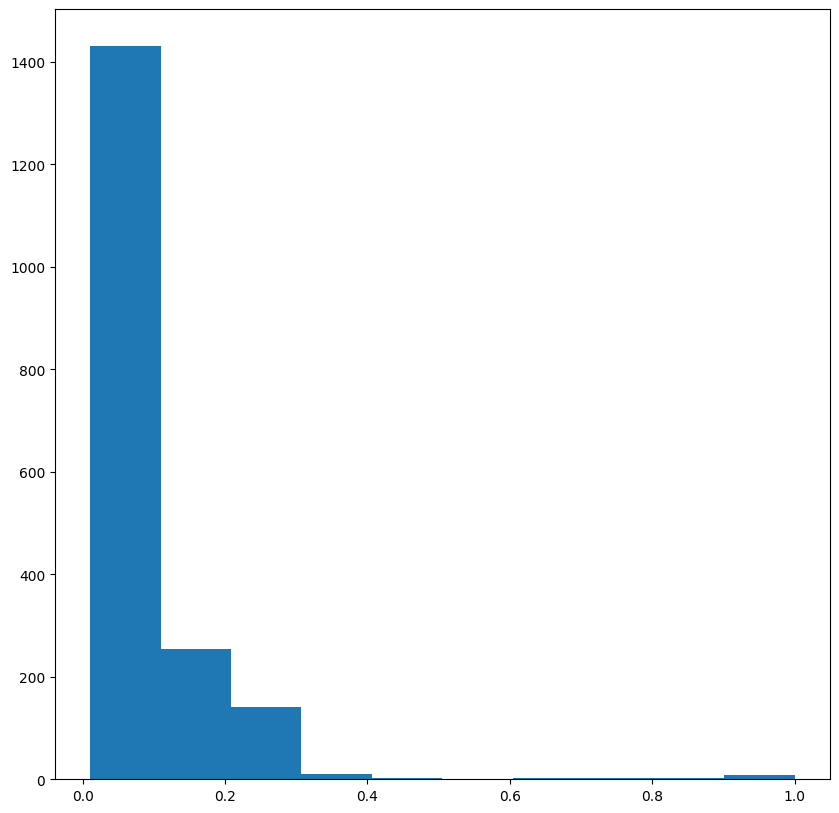

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.hist(dataframes[0]['mm_scaler__mass_concentration_pm10p0'])

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split



# Define the input shape
input_shape = X_all[0].shape
output_shape = y_all.shape[1]
print('Input shape:', input_shape)

# Define the LSTM-based neural network
inputs = Input(shape=input_shape)
lstm_layer = LSTM(128)(inputs)
dense = Dense(64, activation='relu')(lstm_layer)
dense = Dense(32, activation='relu')(dense)
output = Dense(output_shape, 'linear')(dense)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Train the model
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=True)

# Callbacks


early_stopping=EarlyStopping(patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

Input shape: (30, 39)
Epoch 1/50
553/553 [==============================] - 9s 6ms/step - loss: 0.0050 - mae: 0.0374 - val_loss: 0.0019 - val_mae: 0.0225 - lr: 5.0000e-04
Epoch 2/50
553/553 [==============================] - 3s 5ms/step - loss: 0.0020 - mae: 0.0220 - val_loss: 0.0017 - val_mae: 0.0205 - lr: 5.0000e-04
Epoch 3/50
553/553 [==============================] - 3s 5ms/step - loss: 0.0019 - mae: 0.0207 - val_loss: 0.0016 - val_mae: 0.0195 - lr: 5.0000e-04
Epoch 4/50
553/553 [==============================] - 3s 5ms/step - loss: 0.0018 - mae: 0.0200 - val_loss: 0.0016 - val_mae: 0.0192 - lr: 5.0000e-04
Epoch 5/50
553/553 [==============================] - 3s 5ms/step - loss: 0.0018 - mae: 0.0196 - val_loss: 0.0016 - val_mae: 0.0190 - lr: 5.0000e-04
Epoch 6/50
553/553 [==============================] - 3s 5ms/step - loss: 0.0017 - mae: 0.0192 - val_loss: 0.0015 - val_mae: 0.0181 - lr: 5.0000e-04
Epoch 7/50
553/553 [==============================] - 3s 6ms/step - loss: 0.0017 - m

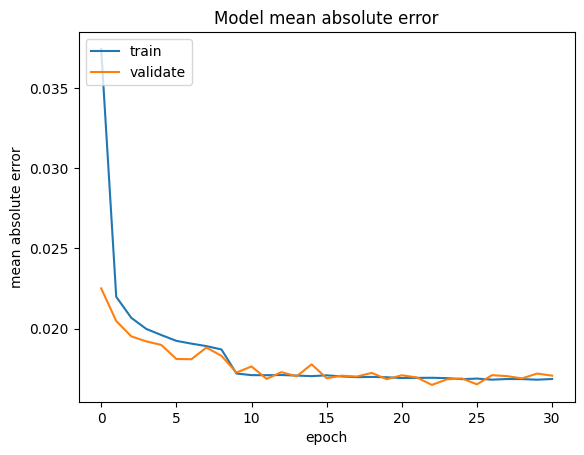

In [34]:
# summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

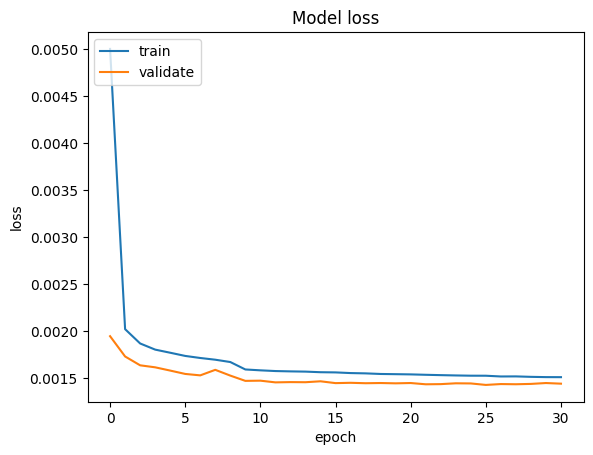

In [33]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [35]:
y_pred = model.predict(X_test)
y_pred.shape

615/615 [==============================] - 2s 2ms/step


(19652, 8)

In [36]:
def inverse_scale(col_trans, data):
  for transformer in col_trans.transformers_:
    if transformer[0] == 'rb_scaler':
      columns_rb = col_trans.output_indices_['rb_scaler']
      data[:, columns_rb] = transformer[1].inverse_transform(data[:, columns_rb])

    elif transformer[0] == 'mm_scaler':
        columns_mm = col_trans.output_indices_['mm_scaler']
        data[:, columns_mm] = transformer[1].inverse_transform(data[:, columns_mm])

    elif transformer[0] == 'time':
        pass
  return data

i_scaled = inverse_scale(col_trans, y_pred)

In [37]:
print(i_scaled[:10])

[[ 49.157536   51.179737   50.502216   50.10646   117.284996   73.18672
   10.826717    1.0990292]
 [  4.351505    5.3868136   7.0785427   7.497482   64.50424    95.073654
    4.8152585   1.1448908]
 [  2.2795546   3.4371912   4.507299    5.115015   73.758675   94.134735
    6.236449    1.0364757]
 [  7.3411837   7.9736457   8.217641    8.0270405  97.525604   61.72999
    7.209395    1.1202503]
 [ 45.754246   48.84442    49.657387   49.748367   51.944836   65.346344
    6.488537    5.0104427]
 [ 12.942643   13.9293785  14.328972   14.724225  204.14214    89.64527
    8.380264    1.0231128]
 [  1.9210324   3.2584422   3.9913666   4.604672   50.18842    75.305565
    9.643599    2.9889238]
 [  5.007159    4.8306713   5.3444386   4.8141017  96.20568    82.03626
    9.752345    2.0930269]
 [ 25.828938   27.69387    27.021536   26.883957  167.02809   100.352196
    7.092094    1.0701994]
 [  4.576112    5.8292575   6.2614      6.4836235 142.1667     52.227444
   15.20606     1.0304759]]


In [38]:
y = inverse_scale(col_trans, y_test)

In [39]:
x_last = [x[-1] for x in X_test]
x_last = np.array(x_last)
print(x_last.shape)

(19652, 39)


In [40]:
x_last = x_last[:, :8]

In [41]:
x_last = inverse_scale(col_trans, x_last)

In [42]:
abs_errors = abs(i_scaled - y)
abs_errors_base = abs(x_last - y)
for i in range(8):
  print('Prediction error: ', abs_errors[:, i].mean())
  print('Baseline error: ', abs_errors_base[:, i].mean(), '\n')

Prediction error:  1.819618106045378
Baseline error:  2.0415989992306036 

Prediction error:  1.979663018916335
Baseline error:  2.28093833280621 

Prediction error:  2.098501997724255
Baseline error:  2.474768522018573 

Prediction error:  2.1961183809646077
Baseline error:  2.582812233880481 

Prediction error:  17.231582114343137
Baseline error:  17.762090825420902 

Prediction error:  0.5706373334833234
Baseline error:  0.3721310945605653 

Prediction error:  0.1759176351219479
Baseline error:  0.0579091229475258 

Prediction error:  0.09886510943046875
Baseline error:  0.04011405600302405 

